<a href="https://colab.research.google.com/github/manarhelmy9847/IoT-Network-Attack-Classification-using-XGBoost/blob/main/Multiclass_IoT_Attack_Classifier_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📌 1. Mount Google Drive and Load Data**

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **📌 2. Extract and Load the Dataset**

In [66]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"manarhelmy5","key":"20473cba846ed7b77b928a6c8817f9c9"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d mkashifn/nbaiot-dataset

Dataset URL: https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset
License(s): unknown
100% 1.75G/1.75G [00:21<00:00, 163MB/s]
100% 1.75G/1.75G [00:21<00:00, 88.9MB/s]


In [5]:
!unzip /content/nbaiot-dataset.zip

Archive:  /content/nbaiot-dataset.zip
  inflating: 1.benign.csv            
  inflating: 1.gafgyt.combo.csv      
  inflating: 1.gafgyt.junk.csv       
  inflating: 1.gafgyt.scan.csv       
  inflating: 1.gafgyt.tcp.csv        
  inflating: 1.gafgyt.udp.csv        
  inflating: 1.mirai.ack.csv         
  inflating: 1.mirai.scan.csv        
  inflating: 1.mirai.syn.csv         
  inflating: 1.mirai.udp.csv         
  inflating: 1.mirai.udpplain.csv    
  inflating: 2.benign.csv            
  inflating: 2.gafgyt.combo.csv      
  inflating: 2.gafgyt.junk.csv       
  inflating: 2.gafgyt.scan.csv       
  inflating: 2.gafgyt.tcp.csv        
  inflating: 2.gafgyt.udp.csv        
  inflating: 2.mirai.ack.csv         
  inflating: 2.mirai.scan.csv        
  inflating: 2.mirai.syn.csv         
  inflating: 2.mirai.udp.csv         
  inflating: 2.mirai.udpplain.csv    
  inflating: 3.benign.csv            
  inflating: 3.gafgyt.combo.csv      
  inflating: 3.gafgyt.junk.csv       
  inflating:

In [13]:
!cp -r /content/nbaiot-dataset.zip /content/drive/MyDrive/N_BaIoT

# **📌 3. Read a Sample of CSVs and Combine Them**

In [15]:
!pip install xgboost

In [67]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [134]:
DATA_DIR = "/content"  # عدّلي حسب مكان الملفات

# ✅ تعيين الملفات والتسميات
files_labels = {
    "/content/1.benign.csv": "benign",
    "/content/1.mirai.ack.csv": "mirai_ack",
    "/content/2.mirai.scan.csv": "mirai_scan",
    "/content/1.mirai.syn.csv": "mirai_syn",
    "/content/1.mirai.udp.csv": "mirai_udp",
    "/content/1.mirai.udpplain.csv": "mirai_udpplain",
    "/content/1.gafgyt.combo.csv": "gafgyt_combo",
    "/content/1.gafgyt.junk.csv": "gafgyt_junk",
    "/content/1.gafgyt.scan.csv": "gafgyt_scan",
    "/content/1.gafgyt.tcp.csv": "gafgyt_tcp"
}


dfs = []
for file, label in files_labels.items():
    path = os.path.join(DATA_DIR, file)
    df = pd.read_csv(path).sample(n=100, random_state=42)
    df["label"] = label
    dfs.append(df)


df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)



## **📌 4. Clean the Dataset**

In [135]:
df_all.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,label
0,111.020065,293.755708,60833.587903,169.344644,328.024606,60566.890423,497.677931,342.512445,59744.204669,5003.806292,...,0.0,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.0,0.0,mirai_udpplain
1,152.435773,74.010765,0.951673,265.238479,74.049930,26.108616,821.551067,74.733144,579.968451,7358.219951,...,0.0,0.0,1.000000,74.0,0.000000e+00,74.000000,0.000000e+00,0.0,0.0,gafgyt_junk
2,180.551496,74.004265,0.102354,294.896570,74.011511,0.276278,869.019750,74.026354,0.661131,7628.030762,...,0.0,0.0,1.000000,74.0,0.000000e+00,74.000000,0.000000e+00,0.0,0.0,gafgyt_junk
3,156.872877,74.077321,1.849717,260.162358,74.068365,1.636081,784.514014,74.052315,1.253240,7431.387348,...,0.0,0.0,1.676769,74.0,9.536743e-07,95.268043,9.094947e-13,0.0,0.0,gafgyt_combo
4,156.183859,270.409953,59669.874477,235.544122,319.727135,60845.545902,654.627369,367.129324,57389.049300,6459.832816,...,0.0,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.0,0.0,mirai_udp


In [136]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 116 entries, MI_dir_L5_weight to label
dtypes: float64(115), object(1)
memory usage: 906.4+ KB


In [137]:
df_all.shape

(1000, 116)

In [138]:
df_all.describe()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,97.107130,160.208316,14651.702325,154.097555,160.768334,16483.654358,439.475263,161.430455,17519.111996,3924.850184,...,0.016000,1.380000e-16,5.501640e-12,850.514619,156.294475,0.018190,161.139947,0.135543,7.212805e-03,1.917645e-04
std,65.121851,147.285297,23322.683335,105.215827,140.985089,25382.855857,308.454672,137.617336,26214.076765,2813.921745,...,0.505964,4.363943e-15,1.739252e-10,3857.456611,187.596629,0.343480,186.271811,2.968741,2.019517e-01,3.916749e-03
min,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.000000,-4.700000e-29,-7.300000e-17,1.000000,60.000000,0.000000,60.000000,0.000000,-5.790000e-28,-1.180000e-16
25%,31.688305,67.079675,0.006538,46.766090,67.922868,0.226252,141.997969,68.827691,1.150264,927.888610,...,0.000000,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000,60.000000,0.000000,0.000000e+00,0.000000e+00
50%,108.147474,74.074400,6.155230,182.361168,74.093039,13.377737,546.970570,74.278550,43.409105,5015.948734,...,0.000000,0.000000e+00,0.000000e+00,1.000000,74.000000,0.000000,74.000000,0.000000,0.000000e+00,0.000000e+00
75%,154.490242,244.342571,31410.844867,244.757230,292.558677,44173.346752,676.330951,335.599227,53158.101616,6405.496349,...,0.000000,0.000000e+00,0.000000e+00,1.678990,98.000000,0.000000,138.592929,0.000000,0.000000e+00,0.000000e+00
max,233.733432,820.402864,65100.378055,351.262787,495.642663,158569.219643,936.633144,439.833461,63398.141050,7907.432687,...,15.999971,1.380000e-13,5.500000e-09,23431.265837,909.000000,8.582966,909.000000,86.485764,6.325175e+00,1.094819e-01


In [139]:
df_all.isnull().sum()

,0
MI_dir_L5_weight,0
MI_dir_L5_mean,0
MI_dir_L5_variance,0
MI_dir_L3_weight,0
MI_dir_L3_mean,0
...,...
HpHp_L0.01_magnitude,0
HpHp_L0.01_radius,0
HpHp_L0.01_covariance,0
HpHp_L0.01_pcc,0


In [140]:
df_all.duplicated().sum()

np.int64(0)

# **📌 5. Basic Analysis — Class Counts**

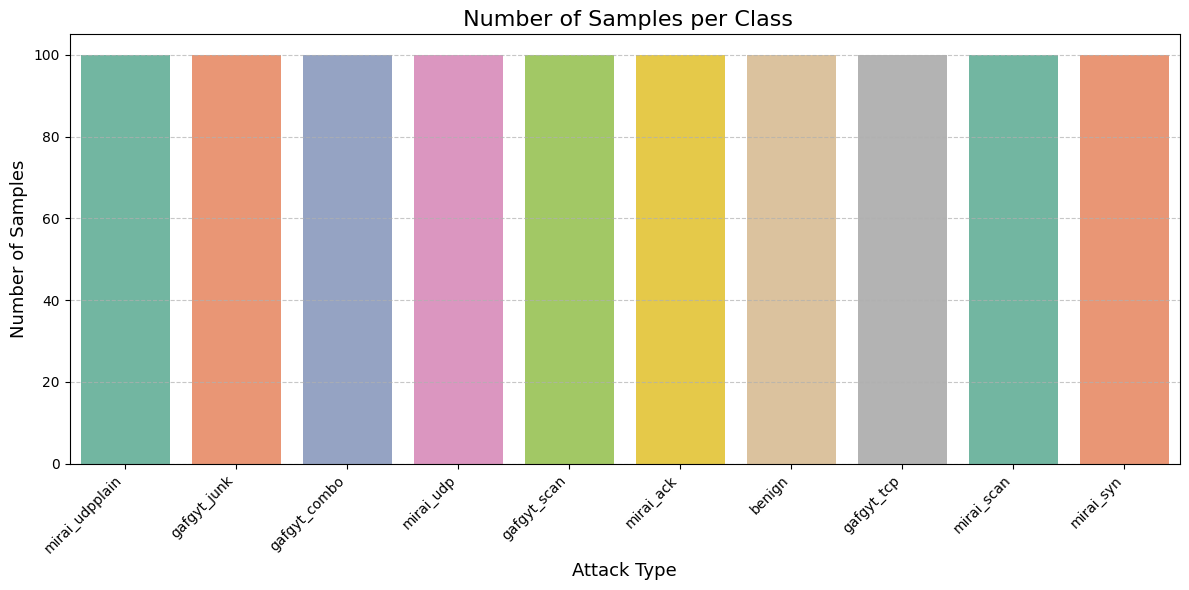

In [141]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_all, x="label", order=df_all["label"].value_counts().index, palette="Set2")
plt.title(" Number of Samples per Class", fontsize=16)
plt.xlabel("Attack Type", fontsize=13)
plt.ylabel("Number of Samples", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **📌 6. Additional Plots: Box, Pair, Violin**

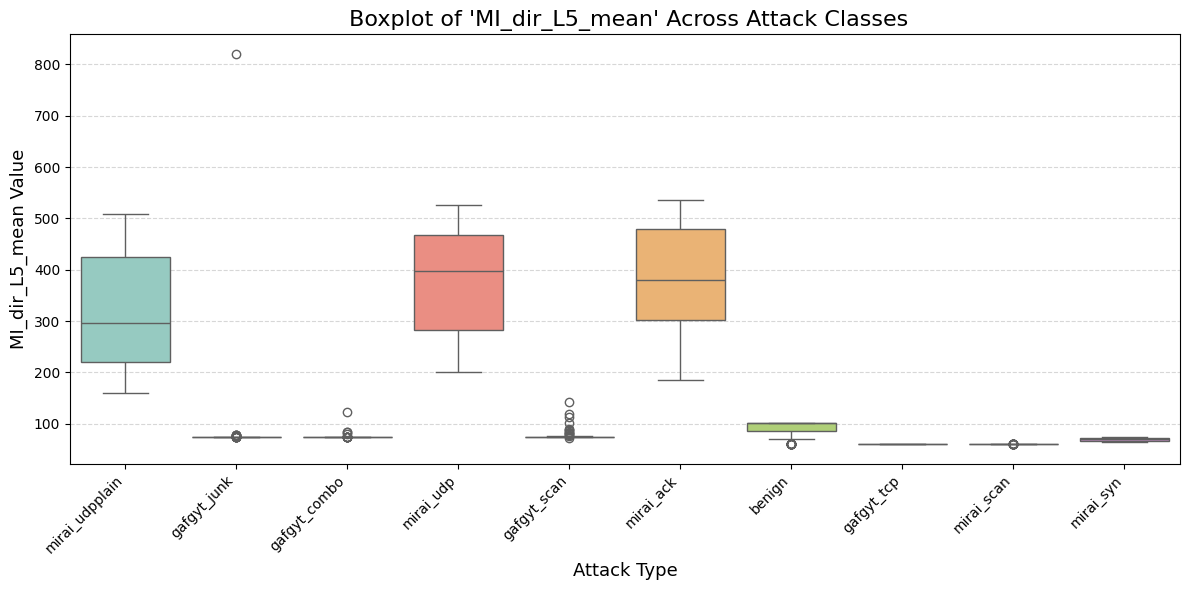

In [142]:
# 1. Boxplot for a numerical feature grouped by class
plt.figure(figsize=(12, 6))
feature_box = df_all.columns[1]
sns.boxplot(data=df_all, x="label", y=feature_box, palette="Set3")
plt.title(f" Boxplot of '{feature_box}' Across Attack Classes", fontsize=16)
plt.xlabel("Attack Type", fontsize=13)
plt.ylabel(f"{feature_box} Value", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

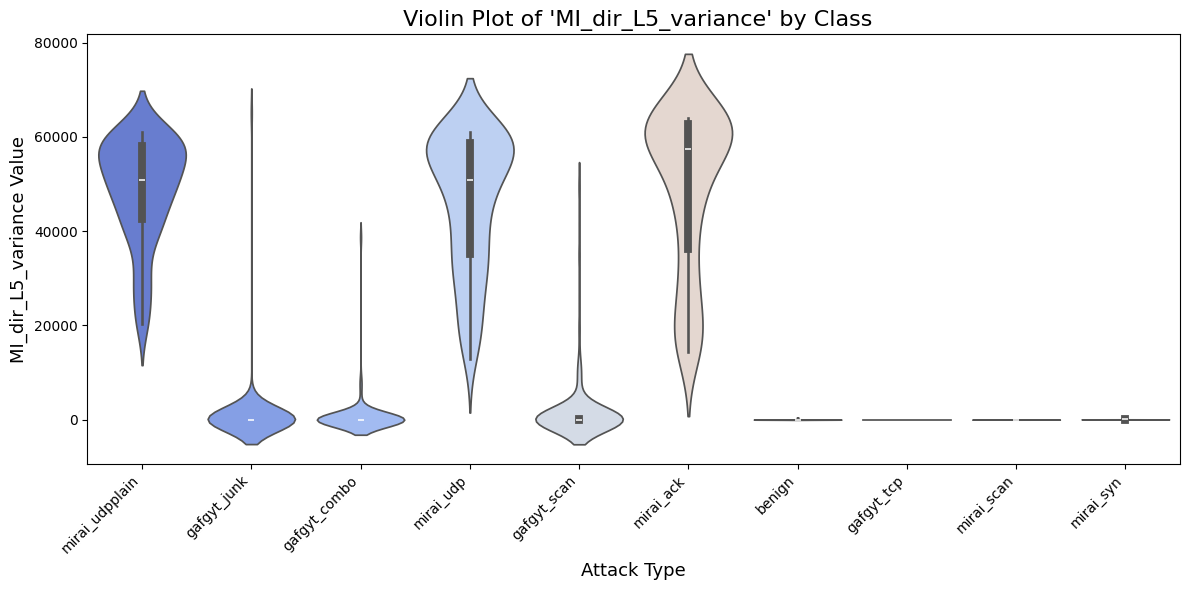

In [144]:
# 3. Violin plot to show distribution and density of a feature
plt.figure(figsize=(12, 6))
feature_violin = df_all.columns[2]
sns.violinplot(data=df_all, x="label", y=feature_violin, palette="coolwarm")
plt.title(f" Violin Plot of '{feature_violin}' by Class", fontsize=16)
plt.xlabel("Attack Type", fontsize=13)
plt.ylabel(f"{feature_violin} Value", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **📌 7. Correlation Heatmap**

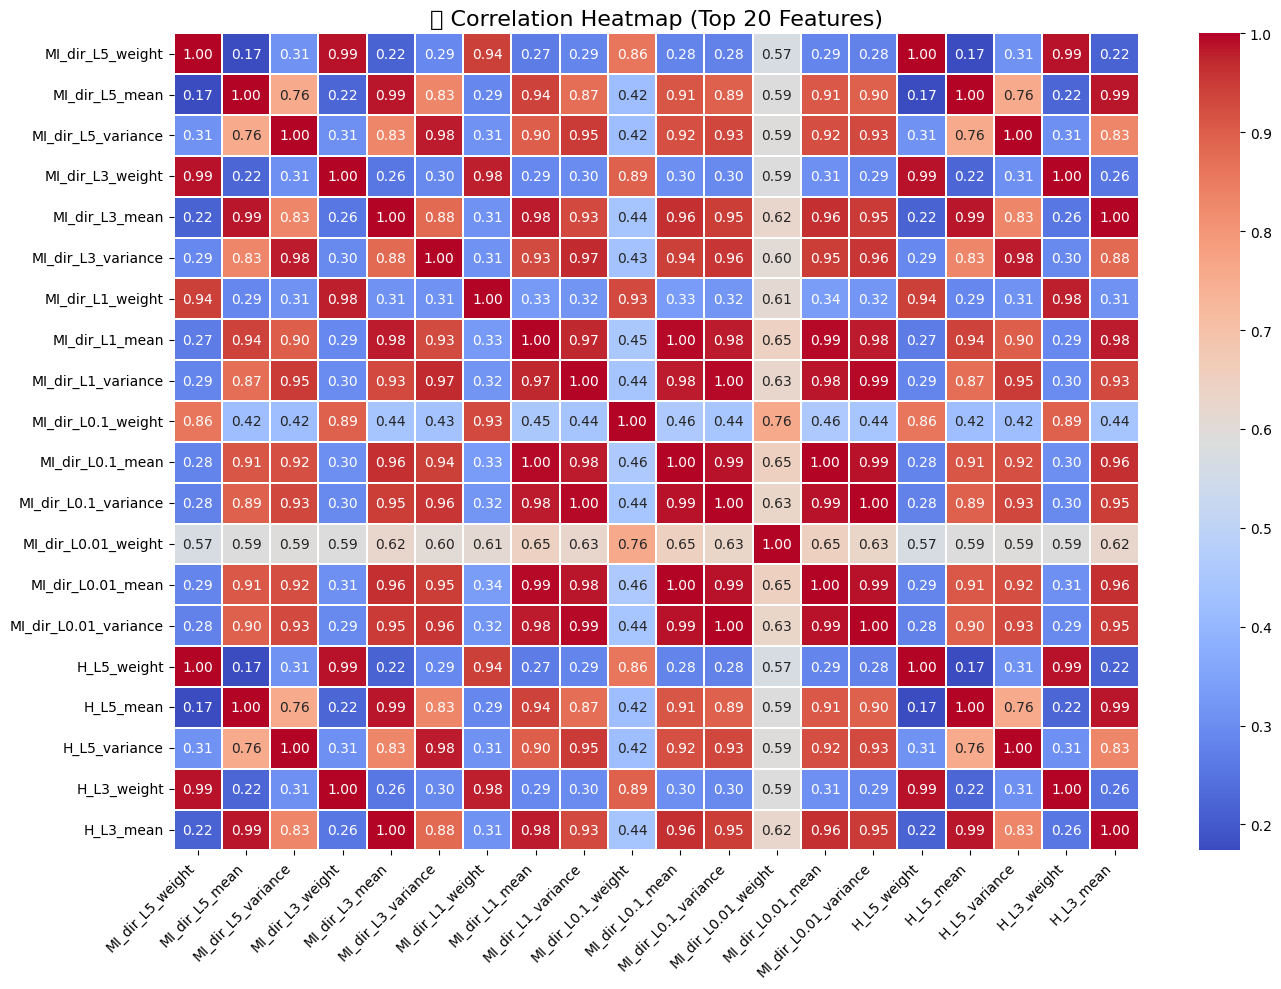

In [145]:
subset = df_all.drop("label", axis=1).iloc[:, :20]
corr = subset.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.2)
plt.title("🔍 Correlation Heatmap (Top 20 Features)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# **📌 8. Train-Test Split**

In [146]:
# 🧪 Split data into features (X) and labels (y)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_all.drop(columns=["label"])
X_reduced = X.iloc[:, :20]
y = df_all["label"]


le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and testing sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_encoded, stratify=y_encoded, test_size=0.5, random_state=42)

print(f" Training set: {X_train.shape}, Testing set: {X_test.shape}")

 Training set: (500, 20), Testing set: (500, 20)


# **📌 9. Train XGBoost Multiclass Classifier**



In [147]:
# Train an XGBoost model for multiclass classification
from xgboost import XGBClassifier
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=10, num_parallel_tree=None, ...)

# **📌 10. Evaluate the Model**

In [148]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f" Accuracy: {acc * 100:.2f}%")

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\n📊 Confusion Matrix:")
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

 Accuracy: 98.00%

📄 Classification Report:
                precision    recall  f1-score   support

        benign       0.98      1.00      0.99        50
  gafgyt_combo       0.98      0.86      0.91        50
   gafgyt_junk       0.88      0.98      0.92        50
   gafgyt_scan       1.00      0.98      0.99        50
    gafgyt_tcp       1.00      1.00      1.00        50
     mirai_ack       1.00      1.00      1.00        50
    mirai_scan       0.98      1.00      0.99        50
     mirai_syn       1.00      0.98      0.99        50
     mirai_udp       1.00      1.00      1.00        50
mirai_udpplain       1.00      1.00      1.00        50

      accuracy                           0.98       500
     macro avg       0.98      0.98      0.98       500
  weighted avg       0.98      0.98      0.98       500


📊 Confusion Matrix:
[[50  0  0  0  0  0  0  0  0  0]
 [ 0 43  7  0  0  0  0  0  0  0]
 [ 0  1 49  0  0  0  0  0  0  0]
 [ 1  0  0 49  0  0  0  0  0  0]
 [ 0  0  0  0 50

# **📌 11. Visualize Confusion Matrix**

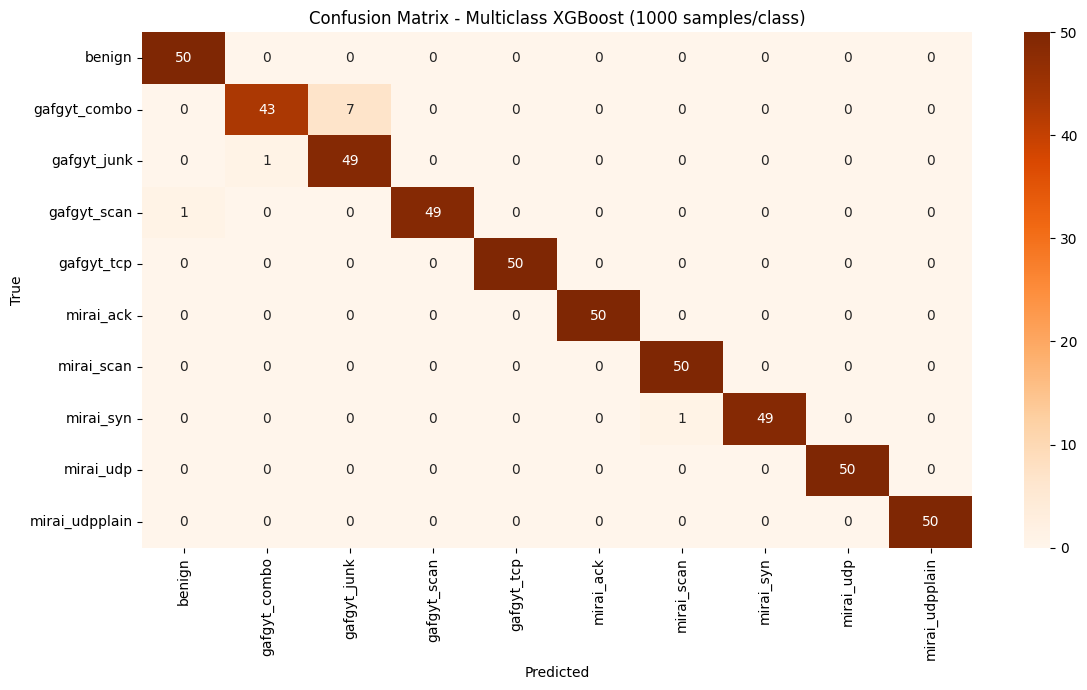

In [149]:
plt.figure(figsize=(12, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Multiclass XGBoost (1000 samples/class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# **📌 12. Save the Model**

In [150]:
#  Save model to file
import joblib

joblib.dump(model, "xgboost_model.pkl")
print(" Model saved as 'xgboost_model.pkl'")


 Model saved as 'xgboost_model.pkl'
